# Error Estimation

In this notebook, we will implement and test **error estimation approaches** for evaluating classifiers and/or learning algorithms.

At the start, we will implement the $k$-fold cross-validation with and without stratification.

Subsequently, we will use the nested $k$-fold cross-validation on an exemplary dataset to perform model selection.

### **Table of Contents**
1. [$k$-fold Cross-alidation](#k-fold-cross-validation)
2. [Model Selection](#model-selection)

In [14]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### **1. $k$-fold Cross-validation** <a class="anchor" id="k-fold-cross-validation"></a>

We implement the function [`cross_validation`](../e2ml/evaluation/_error_estimation.py) in the [`e2ml.evaluation`](../e2ml/evaluation) subpackage. Once, the implementation has been completed, we visualize and compare the standard and stratified cross-validation.

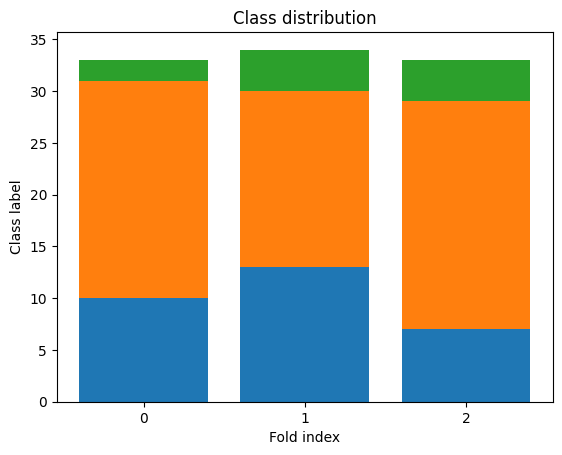

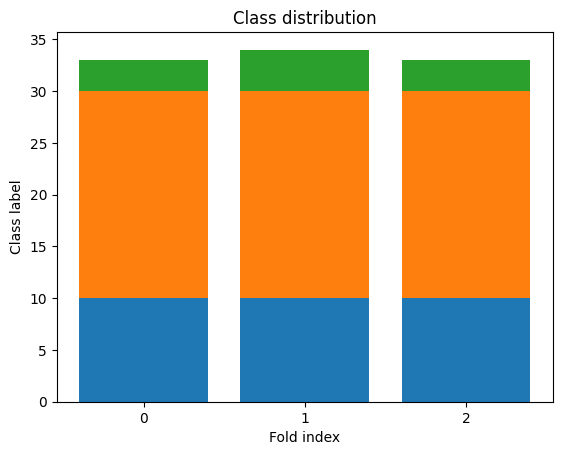

In [15]:
from e2ml.evaluation import cross_validation
# Generate articial class labels.
y = np.zeros(100)
sample_indices = np.arange(len(y), dtype=int)
y[30:90] = 1
y[90:] = 2

def plot_class_distribution(test, y):
    class_distribution = []
    for i, class_y in enumerate(np.unique(y)):
        y_values = []
        for t in test:
            y_values.append(np.sum(y[t] == class_y))
        class_distribution.append(y_values)
        plt.bar(np.arange(len(test)), y_values, bottom=np.sum(class_distribution[:i], axis=0))
        plt.xticks([0,1,2])
        plt.xlabel('Fold index')
        plt.ylabel('Class label')
        plt.title('Class distribution')
    plt.show()

# Visualize standard (k=3)-fold cross validation via a bar plot showing the
# class distribution within each fold.
standard_train, standard_test = cross_validation(sample_indices, n_folds=3, random_state=None)
plot_class_distribution(standard_test, y)
    
# Visualize stratified (k=3)-fold cross validation via a bar plot showing the class
# distribution within each fold.
stratified_train, stratified_test = cross_validation(sample_indices, n_folds=3, random_state=None, y=y)
plot_class_distribution(stratified_test, y)

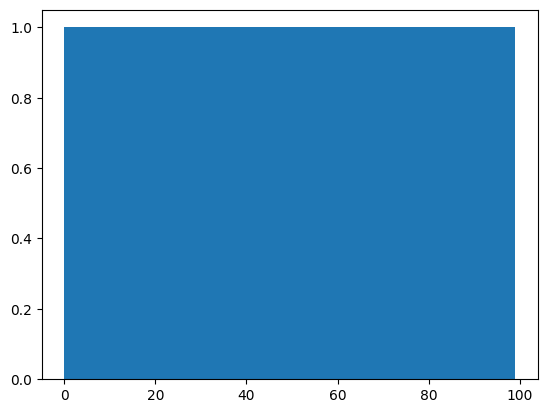

In [21]:
test_elements = []
[test_elements.extend(t) for t in standard_test]
plt.hist(test_elements, bins=100)
plt.show()

### **2. Model Selection** <a class="anchor" id="model-selection"></a>

In the follwing, we perform a small evaluation study including a model selection. Our goal is to compare the learning algorithm of a [*support vector classifier*](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC) (SVC) and a [*multi-layer perceptron*](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html#sklearn.neural_network.MLPClassifier) (MLP) on the data set [*breast cancer*](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_breast_cancer.html#sklearn.datasets.load_breast_cancer). We generate in each run 20 hyperparameter configurations according to one of the popular experimentation methods. Studied hyperparamters are the regularization parameter $C \in (0, 1000)$ (`C`) and the so-called bandwidth $\gamma \in (0, 1]$ (`gamma`) for the SVC, while the learning rate $\eta \in (0, 1]$ (`learning_rate_init`) and another regularization parameter $\alpha \in (0, 1)$ (`alpha`) are studied for the MLP. Further, we use a nested stratified $k=5$-folded cross-valdiation as error-estimation approach. The zero-one loss serves as performance measure to report the emprical mean and standard deviation of the risk estimates.

In [24]:
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.datasets import load_breast_cancer

# Load breast cancer data set.
X, y = load_breast_cancer(return_X_y=True)

# Perform evaluation study.

# Neccesary imports.
from e2ml.evaluation import cross_validation, zero_one_loss
from e2ml.experimentation import halton
from e2ml.preprocessing import StandardScaler

# Define parameters.
n_samples = 20
C_upper = 1000
C_lower = 0
gamma_upper = 1
gamma_lower = 0
lr_upper = 1
lr_lower = 0
alpha_upper = 1
alpha_lower = 0

# Hyperparameter configurations.
theta_svc_list = halton(n_samples, 2, [[C_lower, C_upper], [gamma_lower, gamma_upper]])
theta_mlp_list = halton(n_samples, 2, [[lr_lower, lr_upper], [alpha_lower, alpha_upper]])

# Initialize variables.
risks_svc_outer, risks_mlp_outer = [], []

# Cross validation.
n_folds = 5
sample_indices = np.arange(len(y), dtype=int)
train_outer, test_outer = cross_validation(sample_indices, n_folds=n_folds, random_state=0, y=y)

# Outer k-fold loop. -> test and "rest" (train) set
for _rest, test in zip(train_outer, test_outer): # _rest = train
    # Cross validation.
    train, validation = cross_validation(_rest, n_folds=n_folds, random_state=0, y=y[_rest])

    # Inital best hyperparameters and risk estimates.
    theta_star_svc, theta_star_mlp = [], []
    min_risk_svc, min_risk_mlp = 1, 1

    # Hyperparameter loop.
    for theta_svc, theta_mlp in zip(theta_svc_list, theta_mlp_list): # theta_svc = [C, gamma], theta_mlp = [lr, alpha]
        risks_svc_inner, risks_mlp_inner = [], []

        # Inner k-fold loop. -> train and validation set
        for tr_inner, val_inner in zip(train, validation): # tr_inner = train, va_inner = validation

            # Data preprocessing.
            sc_inner = StandardScaler()
            sc_inner.fit(X[tr_inner])
            X_tr_inner = sc_inner.transform(X[tr_inner])
            X_val_inner = sc_inner.transform(X[val_inner])
            
            # Initialize classifier.
            svc_inner = SVC(C=theta_svc[0], gamma=theta_svc[1], random_state=0)
            mlp_inner = MLPClassifier(learning_rate_init=theta_mlp[0], alpha=theta_mlp[1], random_state=0)

            # Classifier fitting. <- train set
            svc_inner.fit(X_tr_inner, y[tr_inner])
            mlp_inner.fit(X_tr_inner, y[tr_inner])

            # Classifier evaluation. <- validation set
            y_true = y[val_inner]
            y_pred_svc = svc_inner.predict(X_val_inner)
            risks_svc_inner.append(zero_one_loss(y_true, y_pred_svc))
            y_pred_mlp = mlp_inner.predict(X_val_inner)
            risks_mlp_inner.append(zero_one_loss(y_true, y_pred_mlp))
        
        # Update best hyperparameters and risk estimates.
        if np.mean(risks_svc_inner) < min_risk_svc:
            min_risk_svc = np.mean(risks_svc_inner)
            theta_star_svc = theta_svc
        if np.mean(risks_mlp_inner) < min_risk_mlp:
            min_risk_mlp = np.mean(risks_mlp_inner)
            theta_star_mlp = theta_mlp

    # Data preprocessing.
    sc_outer = StandardScaler()
    sc_outer.fit(X[_rest])
    X_tr = sc_outer.transform(X[_rest])
    X_te = sc_outer.transform(X[test])

    # Initialize classifier.
    svc_outer = SVC(C=theta_star_svc[0], gamma=theta_star_svc[1], random_state=0)
    mlp_outer = MLPClassifier(learning_rate_init=theta_star_mlp[0], alpha=theta_star_mlp[1], random_state=0)

    # Classifier fitting. <- train + validation set
    svc_outer.fit(X_tr, y[_rest])
    mlp_outer.fit(X_tr, y[_rest])

    # Classifier evaluation. <- test set
    y_true = y[test]
    y_pred_svc = svc_outer.predict(X_te)
    risks_svc_outer.append(zero_one_loss(y_true, y_pred_svc))
    y_pred_mlp = mlp_outer.predict(X_te)
    risks_mlp_outer.append(zero_one_loss(y_true, y_pred_mlp))

# Print results.
print('SVC: {} +- {}'.format(np.mean(risks_svc_outer), np.std(risks_svc_outer)))
print('MLP: {} +- {}'.format(np.mean(risks_mlp_outer), np.std(risks_mlp_outer)))

# This only gives the risk if the hyperparameters are optimized. The hyperparameters could be different for each fold. Therefore no optimal hyperparameters are found.

SVC:  0.04046171604463254
MLP:  0.03499807618314736


In [26]:
# Print results.
print('SVC: {} +- {}'.format(np.mean(risks_svc_outer), np.std(risks_svc_outer)))
print('MLP: {} +- {}'.format(np.mean(risks_mlp_outer), np.std(risks_mlp_outer)))

SVC: 0.04046171604463254 +- 0.018266911604335308
MLP: 0.03499807618314736 +- 0.028549977230682786
